In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
plt.rcParams['figure.facecolor'] = 'white'

In [8]:
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype) and name[-5]!='t'  :

                b=(str(os.path.join(path, name)))
                data.append(b)
    return data
def sort_on_last(list:list)->list:
    df=pd.DataFrame({'list': list})
    df['nums']=df['list'].apply(lambda x:x.split('_')[-1].split('.')[0])
    df['nums']=df.nums.astype(int)
    df.sort_values(by='nums',inplace=True)
    #display(df)
    return(np.array(df['list']))
path='data/hdf/'
display(gather_universal(path,'.hdf5'))

def get_hdf_main_groups(path) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r.keys()])
        return [str(i) for i in r.keys()]

def get_hdf_group_datasets(path,groupkey) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r[groupkey].keys()])
        return [str(i) for i in r[groupkey].keys()]

def get_df_columns(path)-> pd.DataFrame:
    groups=get_hdf_main_groups(path)
    cols=[]
    for key in groups:
       cols=cols+ list(zip(list(np.full(len(get_hdf_group_datasets(path,key)),key)),
                 get_hdf_group_datasets(path,key)))

    #display(cols)
    columns=pd.MultiIndex.from_tuples(cols, names=('group', 'dataset'))
    #display(pd.DataFrame(columns=columns))
    return columns
def zero_to_nan(array):
    array[array==0.]=np.nan
    return(array)
def steps_to_df(seriespath,examplefilepath)->pd.DataFrame:
    path=seriespath
    series=pd.DataFrame(index=sort_on_last(gather_universal(path,'.hdf5')),columns=get_df_columns(examplefilepath))

    for file in series.index:
        with hdf.File(str(file),'r') as r:
            for location in series.columns:
                series.loc[file,location]=r[location[0]][location[1]][:]
    return series
series=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_A_8yi','data/hdf/series_step_115.hdf5')

['data/hdf/series_step_104.hdf5',
 'data/hdf/series_step_105.hdf5',
 'data/hdf/series_step_106.hdf5',
 'data/hdf/series_step_113.hdf5',
 'data/hdf/series_step_114.hdf5',
 'data/hdf/series_step_115.hdf5',
 'data/hdf/series_step_122.hdf5',
 'data/hdf/series_step_123.hdf5',
 'data/hdf/series_step_124.hdf5',
 'data/hdf/series_step_131.hdf5']

In [9]:
display(series.columns)


MultiIndex([(     'add_data',             'analog_channels'),
            (  'coordinates',                'coordinate_x'),
            (  'coordinates',            'coordinate_x_var'),
            (  'coordinates',                'coordinate_y'),
            (  'coordinates',            'coordinate_y_var'),
            (  'coordinates',                'coordinate_z'),
            (  'coordinates',            'coordinate_z_var'),
            (  'coordinates',           'distance_to_plane'),
            (  'coordinates',          'distance_to_sphere'),
            (  'coordinates',                        'mask'),
            (  'coordinates',             'variance_sphere'),
            ('displacements',          'displacement_total'),
            ('displacements',     'displacement_total_rbmr'),
            ('displacements', 'displacement_total_rbmr_var'),
            ('displacements',      'displacement_total_var'),
            ('displacements',              'displacement_x'),
        

In [79]:
def isnotnan(num):
    return num == num
def linefit(x,y):
    coeffs=np.polyfit(x,y,1)
    poly=np.poly1d(coeffs)
    newy=poly(x)
    return newy
array=series.iloc[530,:][('strains',         'strain_p1')]
def strip_background(array):
    df=pd.DataFrame(array)
    #before=array
    #bf=plt.matshow(before)
    #plt.colorbar(bf)

    after=df.copy()
    after[after==0.]=np.nan
    #display(after)

    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    #display(after)
    """af=plt.matshow(after.dropna(how='all',axis=0))
    plt.colorbar(af)"""
    #display(after)
    return(after)
after=strip_background(array)
display(after.shape)
display(after)

def get_line(df):
    afters=df.copy()
    for column in afters.columns:
        for row in afters.index:
            if isnotnan(afters.loc[row,column]) :
                afters.loc[row,column]=row
    coeffs=np.polyfit(afters.columns,afters.mean(axis=0,skipna=True),1)
    return coeffs

def get_scan_range(df,slope):
    xmin=df.columns.min()
    xmax=df.columns.max()
    ymin=df.index.min()
    ymax=df.index.max()
    pairs=[(xmin,ymin),(xmin,ymax),(xmax,ymin),(xmax,ymax)]
    #display(pairs)
    ts=[pair[1]-(slope*pair[0]) for pair in pairs]
    return (round(min(ts)),round(max(ts)))

display(get_scan_range(after,get_line(after)[0]))


(17, 175)

,27,28,29,30,31,32,33,34,35,36,...,192,193,194,195,196,197,198,199,200,201
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.030336,0.031666,0.046415,0.040334,0.025193,0.030890,0.025477,0.033421,0.030445,0.015354
26,0.038790,0.057155,0.034993,0.037340,0.038132,0.065188,0.058936,0.049402,0.066488,0.045352,...,0.033297,0.025807,0.032285,0.045861,0.034519,0.034342,0.036440,0.022185,0.030263,0.032794
27,0.032320,0.057532,0.038786,0.046435,0.056992,0.048200,0.053392,0.045783,0.058789,0.075392,...,0.051318,0.031695,0.037920,0.025355,0.022774,0.037569,0.043182,0.025644,0.033249,0.029138
28,0.037846,0.045531,0.050703,0.045436,0.044378,0.048642,0.037294,0.059483,0.047742,0.054342,...,0.040450,0.046260,0.045813,0.032075,0.027624,0.039088,0.026779,0.033440,0.033794,0.033434
29,0.039428,0.047561,0.055171,0.048917,0.038137,0.050714,0.072639,0.048496,0.056565,0.046917,...,0.030961,0.048370,0.039797,0.041864,0.031911,0.036052,0.028726,0.032635,0.035451,0.029489
30,0.040623,0.047912,0.054072,0.044855,0.044417,0.048982,0.059858,0.047687,0.035369,0.078603,...,0.037764,0.039163,0.036324,0.036384,0.037391,0.039946,0.029956,0.023563,0.031001,0.032562
31,0.044557,0.053145,0.045473,0.058069,0.051610,0.051605,0.055184,0.032642,0.045023,0.073553,...,0.038648,0.034508,0.045311,0.029806,0.029971,0.049975,0.020334,0.035637,0.035664,0.022030
32,0.052970,0.041001,0.058587,0.052991,0.048242,0.041322,0.042669,0.046694,0.052820,0.056822,...,0.031145,0.049085,0.042028,0.042820,0.030258,0.051070,0.021202,0.047179,0.030350,0.025702
33,0.040177,0.062722,0.063947,0.047480,0.055502,0.050308,0.050608,0.052027,0.055364,0.048134,...,0.038228,0.052921,0.039448,0.041348,0.025328,0.026991,0.023099,0.036055,0.030848,0.034697
34,0.034348,0.035781,0.052315,0.051005,0.047171,0.047018,0.062450,0.040727,0.051878,0.043459,...,0.044560,0.035524,0.047553,0.040146,0.043941,0.042304,0.016720,0.031282,0.038043,0.038011


(25, 43)

<Figure size 1440x1440 with 0 Axes>

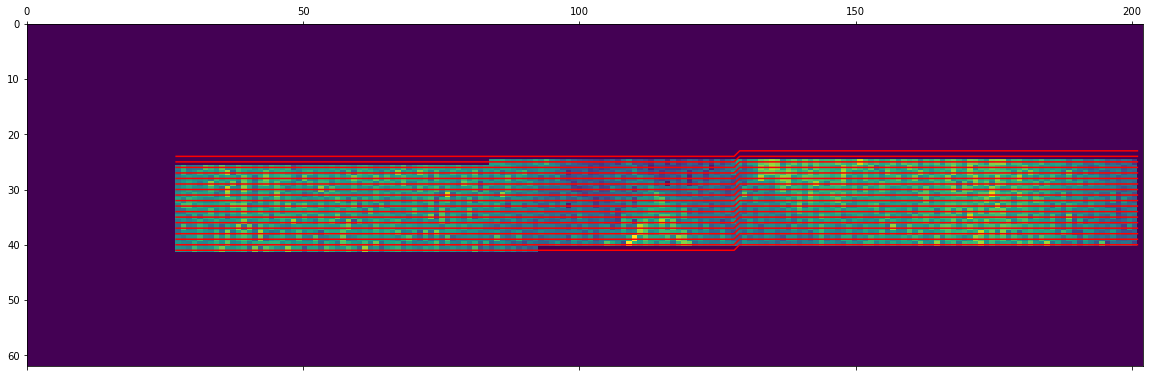

'hello'

In [83]:
#display(dictionary)
import math
plt.figure(figsize=(20,20))
scan_range=get_scan_range(after,get_line(after)[0])
array=pd.DataFrame(array)
fig,ax=plt.subplots(figsize=(20,10))
ax.matshow(array.values,origin='upper',extent=[array.columns[0],array.columns[-1],array.index[-1],array.index[0]])

for i in range(*scan_range,1):
    ax.plot(after.columns, [math.floor(f) for f in  after.columns*get_line(after)[0]+i],c='red')
plt.show()
display('hello')

,27,28,29,30,31,32,33,34,35,36,...,192,193,194,195,196,197,198,199,200,201
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.038790,0.057155,0.034993,0.037340,0.038132,0.065188,0.058936,0.049402,0.066488,0.045352,...,0.030336,0.031666,0.046415,0.040334,0.025193,0.030890,0.025477,0.033421,0.030445,0.015354
27,0.032320,0.057532,0.038786,0.046435,0.056992,0.048200,0.053392,0.045783,0.058789,0.075392,...,0.033297,0.025807,0.032285,0.045861,0.034519,0.034342,0.036440,0.022185,0.030263,0.032794
28,0.037846,0.045531,0.050703,0.045436,0.044378,0.048642,0.037294,0.059483,0.047742,0.054342,...,0.051318,0.031695,0.037920,0.025355,0.022774,0.037569,0.043182,0.025644,0.033249,0.029138
29,0.039428,0.047561,0.055171,0.048917,0.038137,0.050714,0.072639,0.048496,0.056565,0.046917,...,0.040450,0.046260,0.045813,0.032075,0.027624,0.039088,0.026779,0.033440,0.033794,0.033434
30,0.040623,0.047912,0.054072,0.044855,0.044417,0.048982,0.059858,0.047687,0.035369,0.078603,...,0.030961,0.048370,0.039797,0.041864,0.031911,0.036052,0.028726,0.032635,0.035451,0.029489
31,0.044557,0.053145,0.045473,0.058069,0.051610,0.051605,0.055184,0.032642,0.045023,0.073553,...,0.037764,0.039163,0.036324,0.036384,0.037391,0.039946,0.029956,0.023563,0.031001,0.032562
32,0.052970,0.041001,0.058587,0.052991,0.048242,0.041322,0.042669,0.046694,0.052820,0.056822,...,0.038648,0.034508,0.045311,0.029806,0.029971,0.049975,0.020334,0.035637,0.035664,0.022030
33,0.040177,0.062722,0.063947,0.047480,0.055502,0.050308,0.050608,0.052027,0.055364,0.048134,...,0.031145,0.049085,0.042028,0.042820,0.030258,0.051070,0.021202,0.047179,0.030350,0.025702
34,0.034348,0.035781,0.052315,0.051005,0.047171,0.047018,0.062450,0.040727,0.051878,0.043459,...,0.038228,0.052921,0.039448,0.041348,0.025328,0.026991,0.023099,0.036055,0.030848,0.034697


,27,28,29,30,31,32,33,34,35,36,...,192,193,194,195,196,197,198,199,200,201
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.038790,0.057155,0.034993,0.037340,0.038132,0.065188,0.058936,0.049402,0.066488,0.045352,...,0.030336,0.031666,0.046415,0.040334,0.025193,0.030890,0.025477,0.033421,0.030445,0.015354
27,0.032320,0.057532,0.038786,0.046435,0.056992,0.048200,0.053392,0.045783,0.058789,0.075392,...,0.033297,0.025807,0.032285,0.045861,0.034519,0.034342,0.036440,0.022185,0.030263,0.032794
28,0.037846,0.045531,0.050703,0.045436,0.044378,0.048642,0.037294,0.059483,0.047742,0.054342,...,0.051318,0.031695,0.037920,0.025355,0.022774,0.037569,0.043182,0.025644,0.033249,0.029138
29,0.039428,0.047561,0.055171,0.048917,0.038137,0.050714,0.072639,0.048496,0.056565,0.046917,...,0.040450,0.046260,0.045813,0.032075,0.027624,0.039088,0.026779,0.033440,0.033794,0.033434
30,0.040623,0.047912,0.054072,0.044855,0.044417,0.048982,0.059858,0.047687,0.035369,0.078603,...,0.030961,0.048370,0.039797,0.041864,0.031911,0.036052,0.028726,0.032635,0.035451,0.029489
31,0.044557,0.053145,0.045473,0.058069,0.051610,0.051605,0.055184,0.032642,0.045023,0.073553,...,0.037764,0.039163,0.036324,0.036384,0.037391,0.039946,0.029956,0.023563,0.031001,0.032562
32,0.052970,0.041001,0.058587,0.052991,0.048242,0.041322,0.042669,0.046694,0.052820,0.056822,...,0.038648,0.034508,0.045311,0.029806,0.029971,0.049975,0.020334,0.035637,0.035664,0.022030
33,0.040177,0.062722,0.063947,0.047480,0.055502,0.050308,0.050608,0.052027,0.055364,0.048134,...,0.031145,0.049085,0.042028,0.042820,0.030258,0.051070,0.021202,0.047179,0.030350,0.025702
34,0.034348,0.035781,0.052315,0.051005,0.047171,0.047018,0.062450,0.040727,0.051878,0.043459,...,0.038228,0.052921,0.039448,0.041348,0.025328,0.026991,0.023099,0.036055,0.030848,0.034697


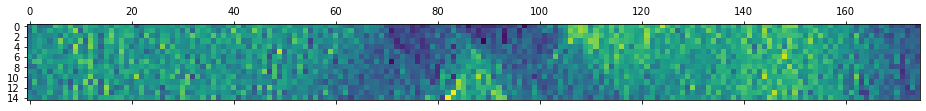

In [85]:
def create_striper(stripped_background:pd.DataFrame):
    after=stripped_background
    scan_range=get_scan_range(after,get_line(after)[0])
    scan_range=range(*scan_range,1)
    res=pd.DataFrame(columns=after.columns,index=scan_range)
    #display(res)
    m=get_line(after)[0]
    for t in res.index:
        for x in res.columns:
            res.loc[t,x]=math.ceil((m*x)+t)
        #display(res.loc[t,:].dtypes)
    for column in res:
        res[column]=res[column].astype(int)
    return res
res=create_striper(after)
def apply_striper(striper,original_array):
    array=original_array
    res=striper

    #res.reset_index(inplace=True,drop=True)

    #display(min(after.index),max(after.index))
    striped=res.loc[range(min(after.index),max(after.index)+1),:].copy()
    #display(striped,after.index)

    #display(striped)
    array=pd.DataFrame(array)
    #display(array)
    for column in striped.columns:

        for index in striped.index:

            striped.loc[index,column]=array.loc[striped.loc[index,column],column]
    #display(striped)
    striped[striped == 0.]=np.nan
    return striped
striped=apply_striper(res,array)
display(striped)
plt.matshow(striped.dropna(axis=0))

plt.show()


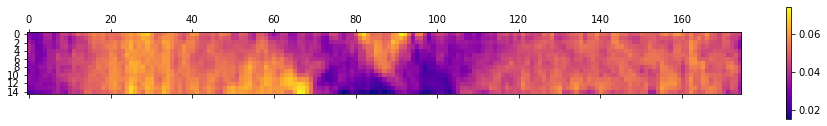

In [102]:
import scipy
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        window_size=window_size+1
        #raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial.
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ...
    # this line gives a list of two item tuple. Each tuple contains
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        """d1=pd.DataFrame(np.linalg.pinv(A)[1].reshape((window_size, -1)))
        d2=pd.DataFrame(np.linalg.pinv(A)[2].reshape((window_size, -1)))
        p=pd.DataFrame(m)
        display(p,p.shape,d1,d1.shape)
        fig,[a,b,c]=plt.subplots(1,3,figsize=(20,15))
        a.matshow(p, label='strain')
        b.matshow(d1,label='strain')
        c.matshow(d2,label='strain')

        X,Y=np.meshgrid(p.columns,p.index)
        fig = plt.figure(figsize=[20,15])
        ax = fig.gca(projection='3d')
        axis = ax.plot_surface(X,Y,p, cmap=cm.viridis,linewidth=5, antialiased=False)
        ax.view_init(30,-50)
        plt.colorbar(axis)"""

        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')


from scipy.signal import savgol_filter as sgy
imf=plt.matshow(np.flip(sgolay2d(np.array(striped.dropna(axis=0)),5,3)),cmap='plasma')
plt.colorbar(imf)